In [85]:
!pip install -q langchain langchain-community langgraph duckduckgo-search tavily-python serpapi ddgs google-search-results langchain-tavily


In [86]:
from typing import Dict, Any, TypedDict, List
from langchain_tavily import TavilySearch
from langchain_community.tools.ddg_search.tool import DuckDuckGoSearchResults
from langchain_community.utilities import SerpAPIWrapper
from langgraph.graph import StateGraph, END

In [87]:
import os
from google.colab import userdata
os.environ["SERPAPI_API_KEY"]=userdata.get('SERPAPI_API_KEY')
os.environ["TAVILY_API_KEY"]=userdata.get('TAVILY_API_KEY')

In [88]:
class AgentState(TypedDict):
    """
    Represents the state of our search agent graph.

    Attributes:
        query: The search query.
        result: The result from a successful search.
        error_message: Any error message encountered during a search attempt.
        successful_agent: The name of the agent that successfully returned a result.
    """
    query: str
    result: Any
    error_message: str
    successful_agent: str

def tavily_agent(state:AgentState) -> Dict[str, Any]:
  """This node perfoms web search using Tavily agent. This is the primary preferred agent."""
  try:
    tavily_tool = TavilySearch(max_results=3)
    result = tavily_tool.invoke({"query" : state["query"]})
    print("Tavily raw result:", result)
    return {"result": result, "successful_agent": "Tavily"}
  except Exception as e:
    print(f"Tavily Search failed: {e}")
    return {"result" : None, "succesful_agent" : None, "error_message" : str(e)}

def ddg_agent(state: AgentState) -> Dict[str, Any]:
    """Fallback: This node performs web search using DuckDuckGo search agent if Tavily fails."""
    try:
        ddg_tool = DuckDuckGoSearchResults()
        result = ddg_tool.invoke({"query": state["query"]})
        return {"result": result, "successful_agent": "DuckDuckGo", "error_message": None}
    except Exception as e:
        print(f"DuckDuckGo Search failed: {e}")
        return {"result": None, "successful_agent": None, "error_message": str(e)}

def serpapi_agent(state: AgentState) -> Dict[str, Any]:
    """Fallback: This node performs web search using SerpAPI (Google) if Tavily and DuckDuckGo fail."""
    try:
        serpapi_tool = SerpAPIWrapper()
        result = serpapi_tool.run(state["query"])
        return {"result": result, "successful_agent": "SerpAPI", "error_message": None}
    except Exception as e:
        print(f"SerpAPI Search failed: {e}")
        return {"result": None, "successful_agent": None, "error_message": str(e)}

def web_search_agent(state: AgentState) -> Dict[str, Any]:
    """Tries agents in order: Tavily -> DuckDuckGo -> SerpAPI"""
    for agent_fn in [tavily_agent, ddg_agent, serpapi_agent]:
        response = agent_fn(state)
        if response["result"] is not None:
            return response  # return first successful result
    return {"result": None, "successful_agent": None, "error_message": "All search agents failed"}



In [89]:
def tavily_node(state: AgentState) -> AgentState:
    response = tavily_agent(state["query"])
    return {**state, **response}

def ddg_node(state: AgentState) -> AgentState:
    response = ddg_agent(state["query"])
    return {**state, **response}

def serp_node(state: AgentState) -> AgentState:
    response = serpapi_agent(state["query"])
    return {**state, **response}


In [90]:
from langgraph.graph import StateGraph, END

workflow = StateGraph(AgentState)

workflow.add_node("tavily", tavily_node)
workflow.add_node("duckduckgo", ddg_node)
workflow.add_node("serpapi", serp_node)

workflow.set_entry_point("tavily")

# --- Conditional edges ---
workflow.add_conditional_edges(
    "tavily",
    # condition function -> must return a string label
    lambda s: "fail" if s["error_message"] else "success",
    {
        "success": END,
        "fail": "duckduckgo"
    },
)

workflow.add_conditional_edges(
    "duckduckgo",
    lambda s: "fail" if s["error_message"] else "success",
    {
        "success": END,
        "fail": "serpapi"
    },
)

# SerpAPI is the last fallback
workflow.add_edge("serpapi", END)

graph = workflow.compile()


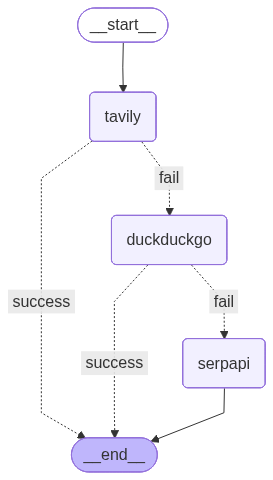

In [91]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

In [92]:
# This passes a dictionary that matches the AgentState structure
initial_state = {"query": "What is the weather in San Francisco?"}
graph.invoke(initial_state)

Tavily Search failed: string indices must be integers, not 'str'
DuckDuckGo Search failed: string indices must be integers, not 'str'
SerpAPI Search failed: Could not import serpapi python package. Please install it with `pip install google-search-results`.


{'query': 'What is the weather in San Francisco?',
 'result': None,
 'error_message': 'Could not import serpapi python package. Please install it with `pip install google-search-results`.',
 'successful_agent': None}